In [1]:
from mdagent import MDAgent
import os 
import mdtraj as md

In [2]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
from robustness_prompts import get_prompt

prompt_9_descriptive = get_prompt("descriptive", 9)
prompt_9_natural = get_prompt("natural", 9)

prompt_9_descriptive, prompt_9_natural

('Complete all of the following tasks: 1. Download the PDB file 1LYZ. 2. Report the secondary structure assignments of the downloaded PDB structure. 3. Find any known binding or active sites. 4. Simulate for 1ps at 300 K. 5. Compute the RMSD. 6. Compute the radius of gyration over time. 7. Compute the SASA (solvent accessible surface area). 8. Simulate for 1ps at 400K. 9. Compute the RMSD of the 400K simulation.',
 'Simulate 1LYZ for 1ps at 300 K and for 1ps at 400K. Report the secondary structure assignments of the downloaded PDB structure and any known binding or active sites. Compute SASA and radius of gyration of the 300K simulation. Compute RMSD of both simulations.')

In [3]:
llm_model = "claude-3-opus-20240229"
tools = "all"

In [4]:
agent_1 = MDAgent(agent_type="Structured", model=llm_model, top_k_tools=tools, use_memory=False)
agent_1.run(prompt_9_descriptive)

Thought: To complete the tasks, I will need to download the PDB file for 1LYZ, analyze its structure, find binding/active sites, run simulations at different temperatures, and compute various structural properties. I will start by downloading the PDB file.

Action:
```
{
  "action": "PDBFileDownloader",
  "action_input": "1LYZ"
}
```

PDB file found with this ID: 1LYZ
Thought: Now that I have the PDB file downloaded, I can analyze the secondary structure using the ComputeDSSP tool.

Action:
```
{
  "action": "ComputeDSSP",
  "action_input": {
    "traj_file": "1LYZ_013240",
    "target_frames": "first"
  }
}
```

Thought: Now that I have the secondary structure information, I will look for any known binding or active sites for this protein using the GetAllKnownSites tool.

Action:
```
{
  "action": "GetAllKnownSites",
  "action_input": {
    "query": "1LYZ",
    "primary_accession": "P00698"
  }
}
```

Thought: Now that I have the PDB structure, secondary structure, and known binding/a

({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

<Figure size 640x480 with 0 Axes>

In [5]:
registry_1 = agent_1.path_registry
print(registry_1.list_path_names_and_descriptions().replace(",", "\n"))

Files found in registry: 1LYZ_013240: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_013240
 rec0_013251: dssp values for trajectory with id: 1LYZ_013240
 1LYZ_013339: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_013354: Initial positions for simulation sim0_013354
 sim0_013354: Basic Simulation of Protein 1LYZ_013339
 rec0_013355: Simulation trajectory for protein 1LYZ_013339 and simulation sim0_013354
 rec1_013355: Simulation state log for protein 1LYZ_013339 and simulation sim0_013354
 rec2_013355: Simulation pdb frames for protein 1LYZ_013339 and simulation sim0_013354
 rmsd_013354: RMSD for 013354
 fig0_013431: RMSD plot for 013354
 rgy_rec0_013355: Radii of gyration per frame for rec0_013355
 fig0_013439: Plot of radii of gyration over time for rec0_013355
 sasa_1LYZ: Total SASA values for 1LYZ
 fig0_013551: Plot of SASA over time for 1LYZ
 top_si

In [6]:
# make sure pdb was downloaded
assert os.path.exists(registry_1.get_mapped_path("1LYZ_013240"))

In [7]:
# make sure dssp was computed correctly
from mdagent.tools.base_tools import ComputeDSSP

dssp = ComputeDSSP(registry_1)
dssp._run(traj_file= "1LYZ_013240", target_frames="first")

"{'residues in helix': 50, 'residues in strand': 14, 'residues in coil': 65, 'residues not assigned, not a protein residue': 101}"

In [8]:
# make sure the sites were found
from mdagent.tools.base_tools import GetAllKnownSites

get_all_known_sites = GetAllKnownSites()
get_all_known_sites._run(query="1LYZ", primary_accession="P00698")

"Active Sites: [{'start': 53, 'start_modifier': 'EXACT', 'end': 53, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}, {'start': 70, 'start_modifier': 'EXACT', 'end': 70, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}]\nBinding Sites: [{'start': 119, 'start_modifier': 'EXACT', 'end': 119, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}]\nNo other relevant sites."

In [10]:
# make sure trajectory and topology exist (sim1)
traj_path_1_1 = registry_1.get_mapped_path("rec0_013355")
top_path_1_1 = registry_1.get_mapped_path("top_sim0_013354")

assert os.path.exists(traj_path_1_1)
assert os.path.exists(top_path_1_1)

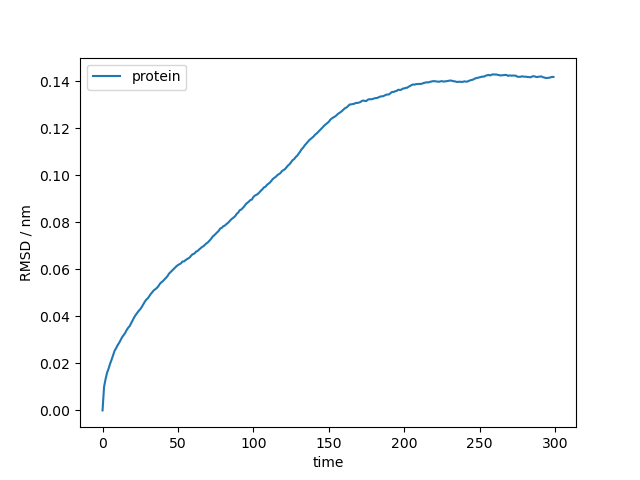

In [11]:
# make sure rmsd plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_013431'))

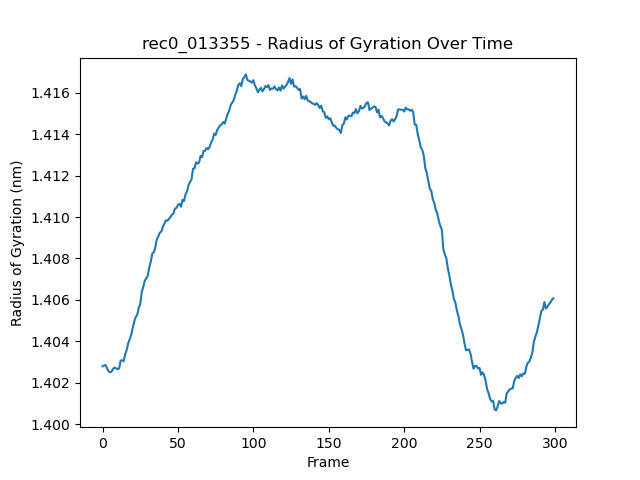

In [12]:
# make sure rgy plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_013439'))

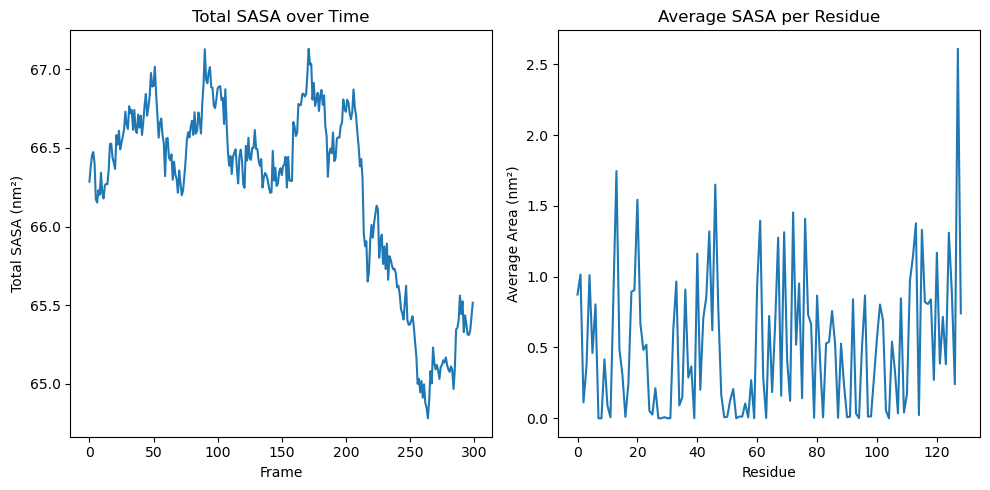

In [13]:
# make sure sasa plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_013551'))

In [14]:
# make sure trajectory and topology exist (sim2)
traj_path_1_2 = registry_1.get_mapped_path("rec0_013605")
top_path_1_2 = registry_1.get_mapped_path("top_sim0_013605")

assert os.path.exists(traj_path_1_2)
assert os.path.exists(top_path_1_2)

In [4]:
agent_2 = MDAgent(agent_type="Structured", model=llm_model, top_k_tools=tools, use_memory=False)
agent_2.run(prompt_9_natural)

Thought: To simulate 1LYZ at different temperatures and analyze the results, I will need to:
1. Download the PDB file for 1LYZ
2. Get information on secondary structure and binding/active sites 
3. Run a 1ps simulation at 300K and analyze SASA and radius of gyration
4. Run a 1ps simulation at 400K 
5. Compute RMSD for both simulations
6. Summarize the results

Action:
```
{
  "action": "PDBFileDownloader",
  "action_input": "1LYZ"
}
```

PDB file found with this ID: 1LYZ
Thought: Now that I have the PDB file for 1LYZ, I will get information on the secondary structure and any known binding or active sites for this protein.

Action:
```
{
  "action": "GetAllKnownSites",
  "action_input": {
    "query": "1LYZ",
    "primary_accession": "P00698"
  }
}
```Here are the next steps:

Thought: I have the PDB file and information on active/binding sites for 1LYZ. Next I will run a 1ps simulation at 300K and analyze the SASA and radius of gyration.

Action:
```
{
  "action": "SetUpandRunFunction"

({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

<Figure size 640x480 with 0 Axes>

In [5]:
registry_2 = agent_2.path_registry
print(registry_2.list_path_names_and_descriptions().replace(",", "\n"))

Files found in registry: 1LYZ_053142: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_053142
 1LYZ_053215: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_053230: Initial positions for simulation sim0_053230
 sim0_053230: Basic Simulation of Protein 1LYZ_053215
 rec0_053234: Simulation trajectory for protein 1LYZ_053215 and simulation sim0_053230
 rec1_053234: Simulation state log for protein 1LYZ_053215 and simulation sim0_053230
 rec2_053234: Simulation pdb frames for protein 1LYZ_053215 and simulation sim0_053230
 sasa_1LYZ: Total SASA values for 1LYZ
 fig0_054519: Plot of SASA over time for 1LYZ
 rgy_rec0_053234: Radii of gyration per frame for rec0_053234
 fig0_054526: Plot of radii of gyration over time for rec0_053234
 top_sim0_054540: Initial positions for simulation sim0_054540
 sim0_054540: Basic Simulation of Protein 1LYZ_053215
 rec0_054544: Sim

In [6]:
# make sure pdb was downloaded
assert os.path.exists(registry_2.get_mapped_path("1LYZ_053142"))

In [7]:
# make sure dssp was computed correctly
from mdagent.tools.base_tools import ComputeDSSP

dssp = ComputeDSSP(registry_2)
dssp._run(traj_file= "1LYZ_053142", target_frames="first")

"{'residues in helix': 50, 'residues in strand': 14, 'residues in coil': 65, 'residues not assigned, not a protein residue': 101}"

In [8]:
# make sure the sites were found
from mdagent.tools.base_tools import GetAllKnownSites

get_all_known_sites = GetAllKnownSites()
get_all_known_sites._run(query="1LYZ", primary_accession="P00698")

"Active Sites: [{'start': 53, 'start_modifier': 'EXACT', 'end': 53, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}, {'start': 70, 'start_modifier': 'EXACT', 'end': 70, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}]\nBinding Sites: [{'start': 119, 'start_modifier': 'EXACT', 'end': 119, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}]\nNo other relevant sites."

In [9]:
# make sure trajectory and topology exist (sim1)
traj_path_2_1 = registry_2.get_mapped_path("rec0_053234")
top_path_2_1 = registry_2.get_mapped_path("top_sim0_053230")

assert os.path.exists(traj_path_2_1)
assert os.path.exists(top_path_2_1)

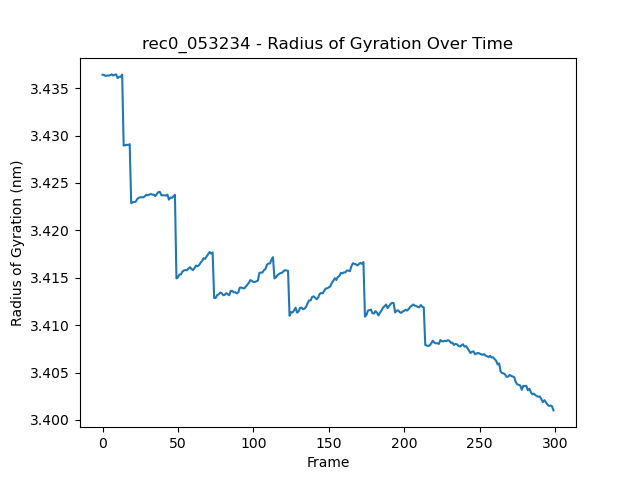

In [11]:
# make sure rgy plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_054526'))

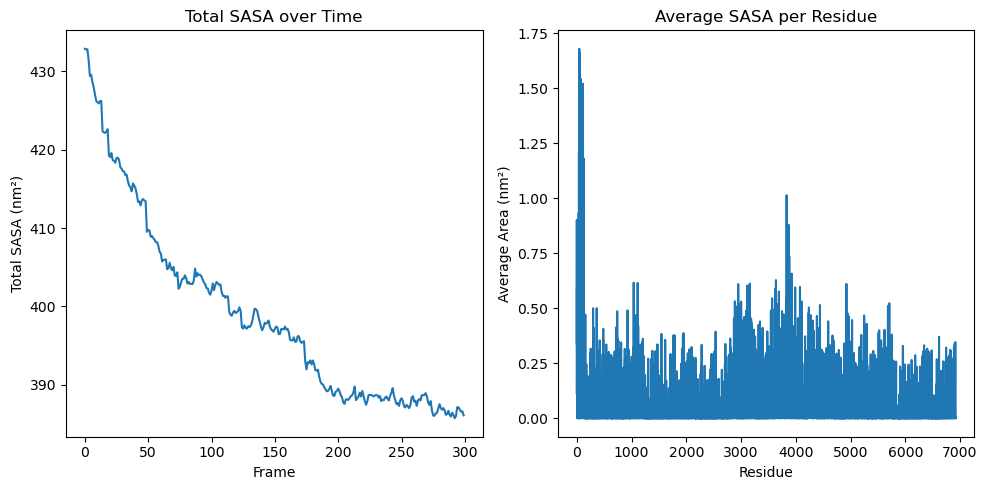

In [10]:
# make sure sasa plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_054519'))

In [12]:
# make sure trajectory and topology exist (sim2)
traj_path_2_2 = registry_2.get_mapped_path("sim0_054540")
top_path_2_2 = registry_2.get_mapped_path("top_sim0_054540")

assert os.path.exists(traj_path_2_2)
assert os.path.exists(top_path_2_2)